In [30]:
import os, sys
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Load prepared dataset
df = pd.read_csv("../data/processed/model_df.csv")

print(df.shape)
df.head()


(110770, 15)


,late_delivery,review_score,order_purchase_dayofweek,order_purchase_hour,estimated_delivery_days,price,freight_value,product_volume_cm3,payment_value,payment_type,customer_state,customer_city,seller_state,seller_city,product_category_name
0,0,4.0,0,10,15,29.99,8.72,1976.0,38.71,credit_card,SP,sao paulo,SP,maua,utilidades_domesticas
1,0,4.0,1,20,19,118.70,22.76,4693.0,141.46,boleto,BA,barreiras,SP,belo horizonte,perfumaria
2,0,5.0,2,8,26,159.90,19.22,9576.0,179.12,credit_card,GO,vianopolis,SP,guariba,automotivo
3,0,5.0,5,19,26,45.00,27.20,6000.0,72.20,credit_card,RN,sao goncalo do amarante,MG,belo horizonte,pet_shop
4,0,5.0,1,21,12,19.90,8.72,11475.0,28.62,credit_card,SP,santo andre,SP,mogi das cruzes,papelaria


In [31]:
# Treatment
T = df["late_delivery"]

# Outcome (not used for propensity model)
Y = df["review_score"]

# Confounders
X = df.drop(columns=["late_delivery", "review_score"])

In [32]:
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_cols, categorical_cols

(['order_purchase_dayofweek',
  'order_purchase_hour',
  'estimated_delivery_days',
  'price',
  'freight_value',
  'product_volume_cm3',
  'payment_value'],
 ['payment_type',
  'customer_state',
  'customer_city',
  'seller_state',
  'seller_city',
  'product_category_name'])

In [33]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Propensity Score Model

## Logistic Regression Propensity Score Model

In [34]:
logit_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=1000))
    ]
)

logit_model.fit(X, T)
propensity_logit = logit_model.predict_proba(X)[:, 1]

print("AUC:", roc_auc_score(T, propensity_logit))

c:\Users\95815\miniconda3\envs\olist-causal\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC: 0.6863530397885549


## Gradient Boosting Propensity Model

In [35]:
gb_model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", GradientBoostingClassifier())
    ]
)

gb_model.fit(X, T)
propensity_gb = gb_model.predict_proba(X)[:, 1]

print("AUC:", roc_auc_score(T, propensity_gb))

AUC: 0.73167523338028


In [36]:
df["ps_logit"] = propensity_logit
df["ps_gb"] = propensity_gb

# Common Support Diagnostics

C:\Users\95815\AppData\Local\Temp\ipykernel_36160\2173882117.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["ps_logit"][T==1], label="Treated", shade=True)
C:\Users\95815\AppData\Local\Temp\ipykernel_36160\2173882117.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["ps_logit"][T==0], label="Control", shade=True)


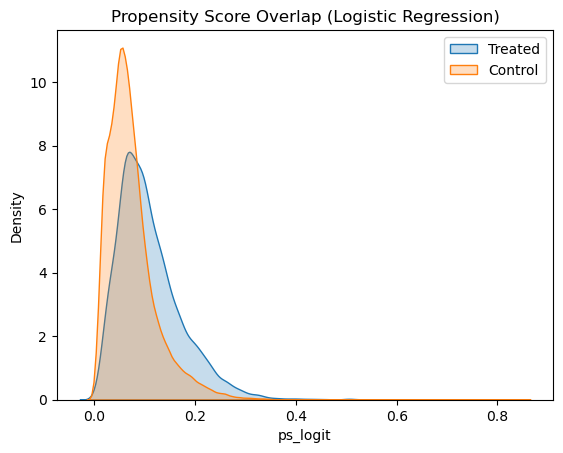

In [37]:
# this section checks positivity assumption
sns.kdeplot(df["ps_logit"][T==1], label="Treated", shade=True)
sns.kdeplot(df["ps_logit"][T==0], label="Control", shade=True)
plt.legend()
plt.title("Propensity Score Overlap (Logistic Regression)")
plt.show()

# Compute Inverse Probability Weights (IPW)

In [38]:
eps = 1e-6

p = df["ps_logit"].clip(eps, 1 - eps)

df["ipw"] = T / p + (1 - T) / (1 - p)
df["ipw_stabilized"] = (T * T.mean() / p) + ((1 - T) * (1 - T.mean()) / (1 - p))

# Covariate Balance Check (SMD)

We use **Standardized Mean Differences (SMD)** to quantify imbalance:

$$
\text{SMD} = \frac{\bar{X}_1 - \bar{X}_0}{\sqrt{(s_1^2 + s_0^2)/2}}
$$

Industry-standard interpretation:
- **|SMD| < 0.1** → good balance  
- **|SMD| < 0.2** → acceptable  
- **|SMD| > 0.2** → concerning imbalance  
- **|SMD| > 0.5** → severe imbalance (model not valid)

In [39]:
def compute_smd_with_preprocess(X, T, weights=None, preprocess=None):
    """
    Compute SMD before/after weighting using the same preprocessing
    used for the propensity score model.
    """

    # 1. Transform X with the preprocessing pipeline
    X_enc = preprocess.transform(X)

    # 2. Convert sparse matrix → dense numpy array
    if hasattr(X_enc, "toarray"):
        X_enc = X_enc.toarray()

    # 3. Ensure all are numeric
    X_enc = X_enc.astype(float)
    T = np.asarray(T).astype(int)

    if weights is not None:
        weights = np.asarray(weights, dtype=float)

    smd_list = []
    for j in range(X_enc.shape[1]):
        x = X_enc[:, j]

        treated = x[T == 1]
        control = x[T == 0]

        if weights is None:
            w_t = None
            w_c = None
        else:
            w_t = weights[T == 1]
            w_c = weights[T == 0]

        m1 = np.average(treated, weights=w_t)
        m0 = np.average(control, weights=w_c)
        s1 = np.sqrt(np.average((treated - m1) ** 2, weights=w_t))
        s0 = np.sqrt(np.average((control - m0) ** 2, weights=w_c))

        smd = (m1 - m0) / np.sqrt((s1**2 + s0**2)/2 + 1e-12)
        smd_list.append(smd)

    return np.array(smd_list)

def get_feature_names(preprocess):
    """Extract feature names from a ColumnTransformer with OneHotEncoder."""
    feature_names = []

    for name, transformer, cols in preprocess.transformers_:
        if transformer == "drop":
            continue
        if transformer == "passthrough":
            feature_names.extend(cols)
            continue

        # OneHotEncoder or other transformers
        if hasattr(transformer, 'get_feature_names_out'):
            fn = list(transformer.get_feature_names_out(cols))
            feature_names.extend(fn)
        else:
            feature_names.extend(cols)

    return feature_names


In [18]:
# Fit preprocess on X
preprocess.fit(X)

# Before weighting
smd_before = compute_smd_with_preprocess(X, T, preprocess=preprocess)

# After weighting
smd_after = compute_smd_with_preprocess(X, T, weights=df["ipw_stabilized"], preprocess=preprocess)


encoded_features = get_feature_names(preprocess)

smd_df = pd.DataFrame({
    "feature": encoded_features,
    "before": smd_before,
    "after": smd_after
})

smd_df.sort_values("before", ascending=False).head(20)

,feature,before,after
29,customer_state_RJ,0.241663,-0.050408
4153,seller_state_SP,0.140356,-0.182531
4,freight_value,0.134830,0.076346
15,customer_state_BA,0.128015,0.033687
3173,customer_city_rio de janeiro,0.117658,-0.065896
3265,customer_city_salvador,0.112937,0.022926
20,customer_state_MA,0.111264,0.063917
3488,customer_city_sao goncalo,0.104442,0.036908
12,customer_state_AL,0.098520,0.103700
16,customer_state_CE,0.094933,0.061975


In [40]:
import joblib

joblib.dump(preprocess, "../models/preprocess_ps.pkl")
X.to_csv("../data/processed/X_ps.csv", index=False)
df.to_csv("../data/processed/model_df_with_ps.csv", index=False)